In [8]:
import numpy as np

In [23]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

In [9]:
import matplotlib.pyplot as plt

In [10]:
Nx = 201
Nt = 101
x = np.zeros(Nx)
u = np.zeros((Nt, Nx))
t = np.zeros(Nt)
ux = np.zeros((Nt, Nx))
uxx = np.zeros((Nt, Nx))

In [11]:
x = np.linspace(-1., 1., Nx)
t = np.linspace(0., 1., Nt)

dx = x[1] - x[0]
dt = t[1] - t[0]
dx, dt

(0.010000000000000009, 0.01)

In [12]:
u[0,:] = -np.sin(np.pi*x)
u[:,0] = u[:,-1] = 0

nu = 0.01/np.pi

In [13]:
u[0,:] = np.sign(x)*0.5
u[:,0] = u[:,-1] = 0

In [14]:
x = np.linspace(0., 1., Nx, endpoint=False) * 2*np.pi
t = np.linspace(0., 1., Nt)

u = np.zeros((Nt, Nx))
ux = np.zeros((Nt, Nx))
uxx = np.zeros((Nt, Nx))

nu = 0.01/np.pi
nu = 0.07
nu = 0.0001
nu = 10.
t = 0
u[0,:] = -2*nu*(-(-8*t + 2*x)*np.exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*np.pi)*np.exp(-(-4*t + x - 2*np.pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(np.exp(-(-4*t + x - 2*np.pi)**2/(4*nu*(t + 1))) + np.exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4
#u[0,-1] = u[0,0]

#u[:,0] = u[:,-1] = 4.

t = np.linspace(0., 1., Nt)

In [9]:
u[0,0], u[0,-1]

(2.2940343526335703, 5.6869380322435585)

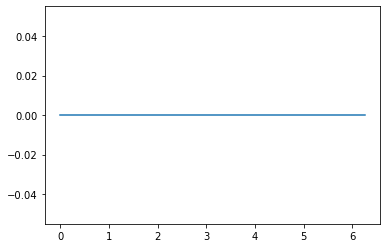

In [10]:
plt.plot(x, uxx[0])

In [11]:
for i in range(1, Nt):
    for j in range(1, Nx-1):
        #ux[i-1, j] = (u[i-1, j+1] - u[i-1, j-1]) / (2. * dx)  # central scheme
        #ux[i-1, j] = (u[i-1, j+1] - u[i-1, j]) / dx
        ux[i-1, j] = (u[i-1, j] - u[i-1, j-1]) / dx
        uxx[i-1, j] = (u[i-1, j+1] - 2*u[i-1, j] + u[i-1, j-1]) / (dx*dx)

        u[i,j] = u[i-1, j] + dt * (-u[i-1, j]*ux[i-1, j] + nu*uxx[i-1, j])
    
    ux[i-1, 0] = (u[i-1, 0] - u[i-1, -1]) / dx
    ux[i-1, -1] = (u[i-1, -1] - u[i-1, -2]) / dx
    uxx[i-1, 0] = (u[i-1, 1] - 2*u[i-1, 0] + u[i-1, -1]) / (dx*dx)
    uxx[i-1, -1] = (u[i-1, 0] - 2*u[i-1, -1] + u[i-1, -2]) / (dx*dx)
    #uxx[i-1, -1] = uxx[i-1, 0]
    #uxx[i-1, -1] = uxx[i-1, 0] = 0.
    u[i,0] = u[i-1, 0] + dt * (-u[i-1, 0]*ux[i-1, 0] + nu*uxx[i-1, 0])
    u[i,-1] = u[i,0]
    
    

C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/2020246098.py:8: RuntimeWarning: overflow encountered in double_scalars
  u[i,j] = u[i-1, j] + dt * (-u[i-1, j]*ux[i-1, j] + nu*uxx[i-1, j])
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/2020246098.py:6: RuntimeWarning: invalid value encountered in double_scalars
  uxx[i-1, j] = (u[i-1, j+1] - 2*u[i-1, j] + u[i-1, j-1]) / (dx*dx)
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/2020246098.py:5: RuntimeWarning: invalid value encountered in double_scalars
  ux[i-1, j] = (u[i-1, j] - u[i-1, j-1]) / dx
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/2020246098.py:8: RuntimeWarning: invalid value encountered in double_scalars
  u[i,j] = u[i-1, j] + dt * (-u[i-1, j]*ux[i-1, j] + nu*uxx[i-1, j])
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/2020246098.py:6: RuntimeWarning: overflow encountered in double_scalars
  uxx[i-1, j] = (u[i-1, j+1] - 2*u[i-1, j] + u[i-1, j-1]) / (dx*dx)
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/20202

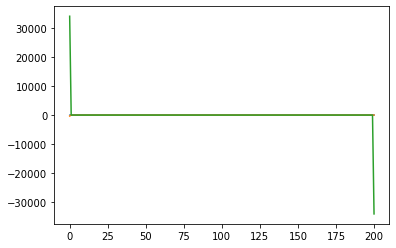

In [12]:
i = 0
plt.plot(u[i])
plt.plot(ux[i])
plt.plot(uxx[i])

In [13]:
np.median(ux[2])

1.7121515921846504

In [14]:
np.shape(u[::10])

(11, 201)

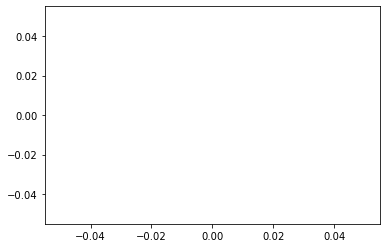

In [15]:
plt.plot(u[30:50:5,75:126].T)

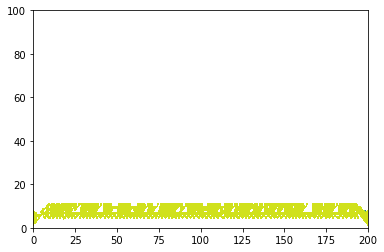

In [16]:
plt.contourf(u)

In [17]:
xx, tt = np.meshgrid(x, t)

In [18]:
from matplotlib import cm

C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/1457652943.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  axes[0].plot_surface(xx.T, tt.T, u.T, cmap=cm.coolwarm)
C:\Users\nilsb\anaconda3\envs\MA_GNN\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/1457652943.py:9: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  axes[1].plot_surface(xx.T, tt.T, ux.T, cmap=cm.coolwarm)
C:\Users\nilsb\AppData\Local\Temp/ipykernel_25608/1457652943.py:10: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  axes[2].plot_surface(xx.T, tt.T, np.clip(uxx.T, -10, 10), cmap=cm.coolwarm)


C:\Users\nilsb\anaconda3\envs\MA_GNN\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


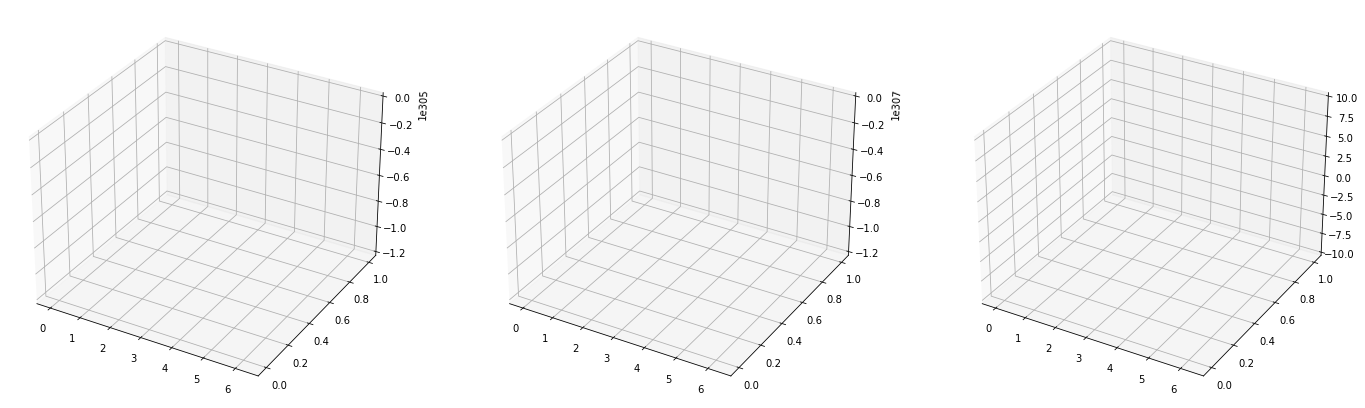

In [19]:


#fig = plt.figure(figsize=(24,8))
#ax = plt.axes(projection='3d')
fig, axes = plt.subplots(1,3, figsize=(24,8), subplot_kw={"projection": "3d"})

#ax.contourf(tt, xx, u)
#ax.contourf(xx.T, tt.T, u.T)

axes[0].plot_surface(xx.T, tt.T, u.T, cmap=cm.coolwarm)
axes[1].plot_surface(xx.T, tt.T, ux.T, cmap=cm.coolwarm)
axes[2].plot_surface(xx.T, tt.T, np.clip(uxx.T, -10, 10), cmap=cm.coolwarm)

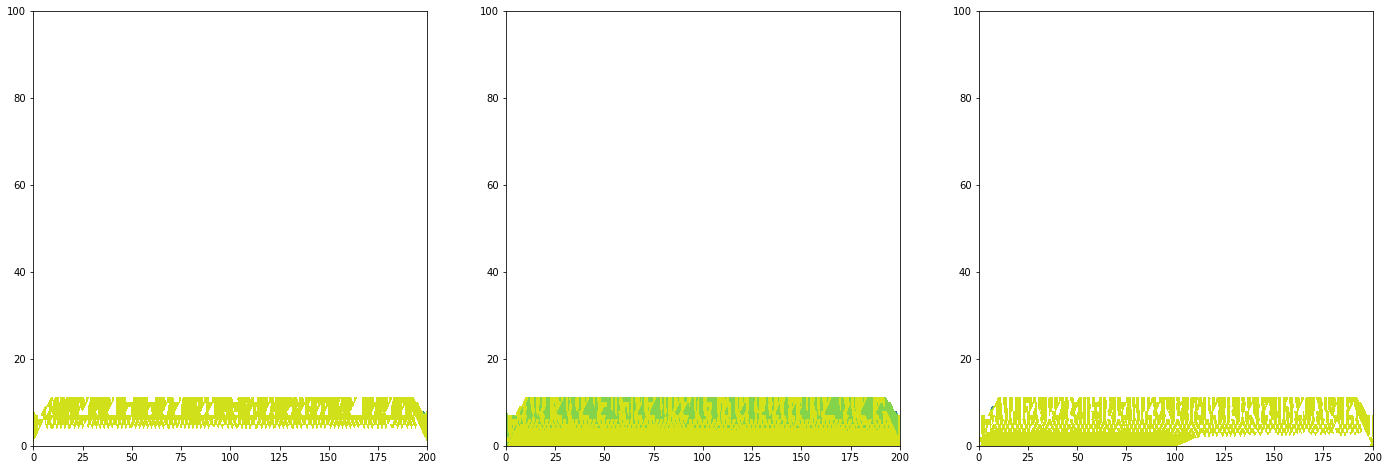

In [20]:

fig, axes = plt.subplots(1,3, figsize=(24,8))

axes[0].contourf(u)
axes[1].contourf(ux)
axes[2].contourf(uxx)

In [21]:
u

array([[ 2.29403435e+00,  2.31306197e+00,  2.33203504e+00, ...,
         5.64904621e+00,  5.66796496e+00,  5.68693803e+00],
       [ 3.42200877e+03,  2.21450290e+00,  2.23347291e+00, ...,
         5.59655702e+00,  5.61505041e+00,  3.42200877e+03],
       [-3.41637226e+06,  3.42738859e+06,  2.14664859e+00, ...,
         5.53559880e+00,  3.41638073e+06, -3.41637226e+06],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

In [1]:
import torch
from torch import nn
import torch.nn.functional as f

In [2]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()

        self.lin1 = nn.Linear(2, 20)
        self.lin21 = nn.Linear(20, 30)
        self.lin22 = nn.Linear(20, 10)
        self.lin31 = nn.Linear(40, 20)
        self.lin32 = nn.Linear(40, 10)
        self.lin4 = nn.Linear(30, 1)

        # self.selu1 = nn.Tanh()
        # self.selu2 = nn.Tanh()
        # self.selu3 = nn.Tanh()
        self.selu1 = nn.Sigmoid()
        self.selu2 = nn.Sigmoid()
        self.selu3 = nn.Sigmoid()
        

        #self.dropout = nn.AlphaDropout(p=0.05)
        self.dropout = nn.Dropout(p=0.0)

        self.theta1 = torch.zeros(1)
        self.theta2 = torch.zeros(1)


    def forward(self, x, t):

        xt = torch.concat((x.reshape(-1,1),t.reshape(-1,1)), dim=1)
        #xt = torch.vstack((x,t))
        #print(xt.shape)


        z1 = self.dropout(self.selu1(self.lin1(xt)))

        z21 = self.dropout(self.selu2(self.lin21(z1)))
        #z22 = self.dropout(torch.sin(self.lin22(z1)))
        z22 = self.dropout(self.selu2(self.lin22(z1)))
        #print(z21.shape, z22.shape)
        z2 = torch.concat((z21, z22), dim=1)

        z31 = self.dropout(self.selu3(self.lin31(z2)))
        #z32 = self.dropout(torch.sin(self.lin32(z2)))
        z32 = self.dropout(self.selu3(self.lin32(z2)))
        z3 = torch.concat((z31, z32), dim=1)

        y = self.lin4(z3)

        return y

    def res(self, x, t):

        u = self.forward(x, t)

        ux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True, retain_graph=True)[0]
        ut = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

        return ut + u*ux - 0.01/torch.pi*uxx
        

    #def residual(self, u):





In [3]:
g = torch.Generator(device="cuda")
g.seed()
#g.manual_seed(42)

1231194341779081

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
net = NNModel().to(device)

In [6]:
#optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(net.parameters())

In [15]:
loss_history = []

for i in range(10_000):
    x_samples = torch.rand((1000), generator=g, device=device).requires_grad_()
    t_samples = torch.rand((1000), generator=g, device=device).requires_grad_()
    x_samples = 2*x_samples - 1.

    # u_samples = net(x_samples, t_samples)
    # ux_samples = torch.empty_like(u_samples)
    # uxx_samples = torch.empty_like(u_samples)
    # ut_samples = torch.empty_like(u_samples)
    # for j in range(1000):
    #     print(j)
    #     ux_samples[j,0] = torch.autograd.grad(u_samples[j,0], x_samples[j,0], retain_graph=True)
    #     uxx_samples[j,0] = torch.autograd.grad(ux_samples[j,0], x_samples[j,0], retain_graph=True)
    #     ut_samples[j,0] = torch.autograd.grad(u_samples[j,0], x_samples[j,0], retain_graph=True)

    # eye = torch.eye(1000, device=device)
    # eye_v = tuple(eye[i] for i in range(1000))

    # ux_samples = torch.autograd.grad(u_samples, (x_samples[i] for i in range(1000)), retain_graph=True)
    # ux_samples = torch.autograd.grad(u_samples, x_samples, create_graph=True, retain_graph=True, allow_unused=True)
    # uxx_samples = torch.autograd.grad(ux_samples, x_samples, create_graph =True)
    # ut_samples = torch.autograd.grad(u_samples, t_samples, create_graph =True)
    
    # ux_samples = torch.autograd.functional.vjp(lambda x: net(x, t_samples), x_samples, eye_v, create_graph=True)

    # res_samples = ut_samples + u_samples*ux_samples - 0.01/np.pi*uxx_samples
    res_samples = net.res(x_samples, t_samples)    
    
    x_boundary1 = torch.rand((1000,1), generator=g, device=device)
    t_boundary1 = torch.zeros((1000,1), device=device)
    x_boundary1 = 2*x_boundary1 - 1.

    u_boundary1 = net(x_boundary1, t_boundary1)
    u_boundary1_target = -torch.sin(torch.pi*x_boundary1)

    x_boundary2 = torch.bernoulli(torch.ones((5000, 1), device=device)*0.5)*2. - 1.
    t_boundary2 = torch.rand((5000,1), generator=g, device=device)
    u_boundary2 = net(x_boundary2, t_boundary2)
    u_boundary2_target = torch.zeros((5000,1), device=device)

    loss1 = torch.sum(res_samples*res_samples)/1000 
    loss2 = f.mse_loss(u_boundary1, u_boundary1_target)
    loss3 = f.mse_loss(u_boundary2, u_boundary2_target)
    loss = 0.01*loss1 + 100*loss2 + loss3

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100==0:
        loss_history.append(loss.detach().cpu().squeeze())
        print(i, np.mean(loss_history), loss1.detach().cpu().squeeze(), loss2.detach().cpu().squeeze(), loss3.detach().cpu().squeeze())
        loss_history = []



0 62.127235 tensor(0.0015) tensor(0.6203) tensor(0.1013)
100 50.53229 tensor(0.0003) tensor(0.5053) tensor(0.0004)
200 34.94564 tensor(1.7286) tensor(0.3486) tensor(0.0686)
300 19.61579 tensor(164.7391) tensor(0.1733) tensor(0.6380)
400 19.024225 tensor(163.3779) tensor(0.1677) tensor(0.6189)
500 19.339005 tensor(163.2278) tensor(0.1710) tensor(0.6046)
600 17.21531 tensor(173.1861) tensor(0.1489) tensor(0.5938)
700 16.948349 tensor(174.6721) tensor(0.1464) tensor(0.5591)
800 14.645118 tensor(186.1126) tensor(0.1227) tensor(0.5181)
900 12.765639 tensor(204.2523) tensor(0.1024) tensor(0.4817)
1000 11.741187 tensor(245.4229) tensor(0.0885) tensor(0.4326)
1100 11.526122 tensor(260.9914) tensor(0.0853) tensor(0.3903)
1200 10.347012 tensor(274.3499) tensor(0.0723) tensor(0.3743)
1300 10.062836 tensor(287.6565) tensor(0.0683) tensor(0.3542)
1400 8.944047 tensor(265.6048) tensor(0.0597) tensor(0.3202)
1500 8.173306 tensor(260.9186) tensor(0.0528) tensor(0.2854)
1600 7.9979916 tensor(299.2766) 

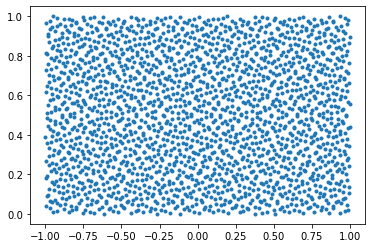

In [21]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=2, scramble=True)
n_samples = 2048

s = sampler.random_base2(11)
s.shape

x_samples = s[:,0]*2 - 1
t_samples = s[:,1]

plt.scatter(x_samples, t_samples, marker='.')

In [48]:
# ich brauch noch boundaries

boundary_nodes = np.array([[0, 0], [0, 0.5], [0, 1], [0.5, 0], [0.5, 1], [1, 0], [1, 0.5], [1, 1]])
n_boundary_nodes = len(boundary_nodes)
boundary_nodes.shape

(8, 2)

In [49]:
n_points = n_samples

bnode_indices = list(range(n_points, n_points+n_boundary_nodes))

nodes_lvl = list(range(n_points))
n_nodes_lvl = n_points
graph_dict = {0: nodes_lvl + bnode_indices}

for i in range(1, 10):
    n_nodes_lvl = n_nodes_lvl // 2
    #print(i, n_nodes_lvl)
    nodes_lvl = sorted(np.random.choice(nodes_lvl, n_nodes_lvl, replace=False))
    graph_dict[i] = nodes_lvl + bnode_indices
    print(i, len(graph_dict[i]))

test_nodes = list(set(graph_dict[0]) - set(graph_dict[1]))

1 1032
2 520
3 264
4 136
5 72
6 40
7 24
8 16
9 12


In [50]:
class Mesh:
    def __init__(self, points):
        self.points = np.asarray(points)

mesh = Mesh(np.vstack((s, boundary_nodes)))

(-0.16666666666666663, 1.1666666666666665)

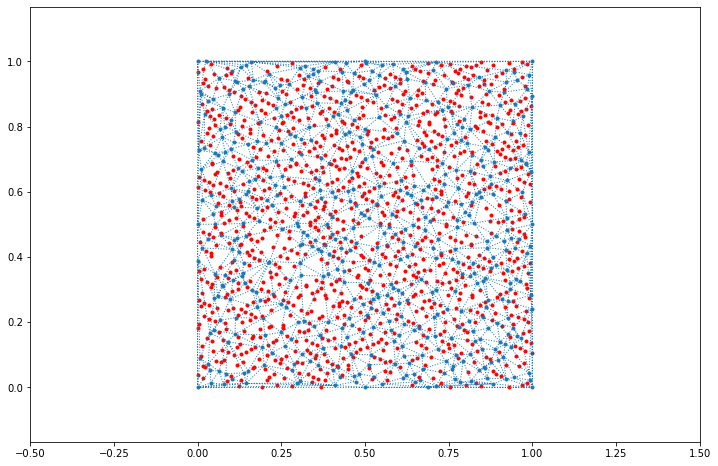

In [53]:
i = 2
nodes_lvl = graph_dict[i]

tri = Delaunay(mesh.points[nodes_lvl,:2])

fig_width = 12
fig_height = 8
center = [0.5, 0.5]
data_max = [0, 1]
data_min = [0, 1]
data_width = 1
data_hwidth = 1

zoom = 1

xmin = center[0] - data_hwidth/zoom
xmax = center[0] + data_hwidth/zoom
ymin = center[1] - data_hwidth/zoom*fig_height/fig_width
ymax = center[1] + data_hwidth/zoom*fig_height/fig_width

plt.figure(figsize=(fig_width, fig_height))
plt.scatter(mesh.points[nodes_lvl,0], mesh.points[nodes_lvl,1], marker=".")
plt.scatter(mesh.points[test_nodes,0], mesh.points[test_nodes,1], marker=".", c="red")
plt.triplot(mesh.points[nodes_lvl,0], mesh.points[nodes_lvl,1], tri.simplices, lw=1, linestyle=":")
plt.xlim([-2., 3.])
plt.ylim([-1, 1])

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

In [96]:
I = np.eye(n_points+n_boundary_nodes)

#i = 2

max_lvl = 5
#w = np.zeros((max_lvl, 1024, 2056))
w = np.zeros((max_lvl, 2056, 2056))

for i in range(0, max_lvl):
    nodes_lvl = graph_dict[i]

    tri = Delaunay(mesh.points[nodes_lvl,:2])
    qoi_lvl = I[nodes_lvl]

    interp = LinearNDInterpolator(tri, qoi_lvl)

    #w[i] = interp(mesh.points[test_nodes,:2])
    w[i] = interp(mesh.points)

In [ ]:
# für die Bestimmung der Residuen benötige ich die Ableitungen von w
# vllt über Differenzvektor zum Mittelpunkt xm = (x1 + x2 + x3) / 3 ?

# ||(xm - xp)|| vs. ||([0.333, 0.333, 0.333] - w)||

# (xp - xm) / (x1 - xm) + 0.5 = w1 * 3/2
# dw1_dxp = d[2/3 * (xp - xm) / (x1 - xm)] / dxp = 2/3 * 1 / (x1 - xm) ==> stimmt das?


dw_dx = ?
dw_dt = ?

In [98]:
train_nodes = test_nodes.copy()
np.random.shuffle(train_nodes)
val_nodes = train_nodes[768:]
train_nodes = train_nodes[:768]
len(val_nodes)

256

In [ ]:
qoi = res

In [97]:
512 + 256

768

In [70]:
w.shape

(5, 1024, 2056)

In [63]:
w[0].sum()

1.0

In [126]:
lvl = 2
i = 9
inds = w[lvl][i].nonzero()[0]
inds, w[lvl][i][inds]

(array([9], dtype=int64), array([1.]))

In [127]:
i in graph_dict[lvl], i in test_nodes

(True, False)

In [65]:
w[0].nonzero()

(array([ 640, 1088, 2050], dtype=int64),)

In [67]:
w[0, [640, 1088, 2050]]

array([0.27476982, 0.54653912, 0.17869107])

In [72]:
w[2][0, [640, 1088, 2050]]

array([0.27476982, 0.54653912, 0.17869107])

In [54]:
net = net.train(False)
net = net.train(True)

In [55]:
u_test = net(torch.from_numpy(xx.flatten()).float().to(device=device), torch.from_numpy(tt.flatten()).float().to(device=device))

NameError: name 'xx' is not defined

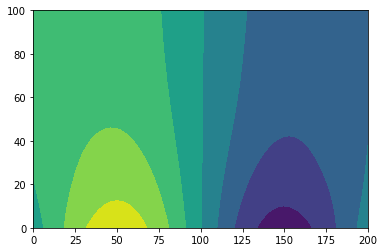

In [ ]:
plt.contourf(u_test.reshape(xx.shape).detach().cpu().numpy())

In [1]:
xx.shape

NameError: name 'xx' is not defined

In [ ]:
class NNModel2(nn.Module):
    def __init__(self):
        super(NNModel2, self).__init__()

        self.nodeEmb = nn.Embedding(4*1032, 8) # lvl*nodes*embdim

        self.lin1 = nn.Linear(8, 20)
        self.lin21 = nn.Linear(20, 30)
        self.lin22 = nn.Linear(20, 10)
        self.lin31 = nn.Linear(40, 20)
        self.lin32 = nn.Linear(40, 10)
        self.lin4 = nn.Linear(30, 1)

        # self.selu1 = nn.Tanh()
        # self.selu2 = nn.Tanh()
        # self.selu3 = nn.Tanh()
        self.selu1 = nn.Sigmoid()
        self.selu2 = nn.Sigmoid()
        self.selu3 = nn.Sigmoid()
        

        #self.dropout = nn.AlphaDropout(p=0.05)
        self.dropout = nn.Dropout(p=0.0)

        self.theta1 = torch.zeros(1)
        self.theta2 = torch.zeros(1)


    def forward(self, x, t):

        xt = torch.concat((x.reshape(-1,1),t.reshape(-1,1)), dim=1)
        #xt = torch.vstack((x,t))
        #print(xt.shape)


        z1 = self.dropout(self.selu1(self.lin1(xt)))

        z21 = self.dropout(self.selu2(self.lin21(z1)))
        #z22 = self.dropout(torch.sin(self.lin22(z1)))
        z22 = self.dropout(self.selu2(self.lin22(z1)))
        #print(z21.shape, z22.shape)
        z2 = torch.concat((z21, z22), dim=1)

        z31 = self.dropout(self.selu3(self.lin31(z2)))
        #z32 = self.dropout(torch.sin(self.lin32(z2)))
        z32 = self.dropout(self.selu3(self.lin32(z2)))
        z3 = torch.concat((z31, z32), dim=1)

        y = self.lin4(z3)

        return y

    def res(self, x, t):

        u = self.forward(x, t)

        ux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True, retain_graph=True)[0]
        ut = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

        return ut + u*ux - 0.01/torch.pi*uxx

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        #loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader
    
    def res(self, x, t):
        u = self.model.forward(x, t)

        ux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True, retain_graph=True)[0]
        ut = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

        return ut + u*ux - 0.01/torch.pi*uxx



In [ ]:
import torchdyn
from torchdyn.core import NeuralODE

In [ ]:
model = NeuralODE(net, sensitivity='adjoint', solver='dopri5').to(device)



In [ ]:
model

Neural ODE:
	- order: 1        
	- solver: DormandPrince45()
	- adjoint solver: DormandPrince45()        
	- tolerances: relative 0.001 absolute 0.001        
	- adjoint tolerances: relative 0.0001 absolute 0.0001        
	- num_parameters: 2161        
	- NFE: 0.0

In [ ]:
f = nn.Sequential(
        nn.Linear(3, 16),
        nn.Tanh(),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )
t_span = torch.linspace(0, 1, 5)



In [ ]:
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
os.getcwd()

'c:\\Users\\nilsb\\Workspace\\GitHub\\MA_GNN\\Code'

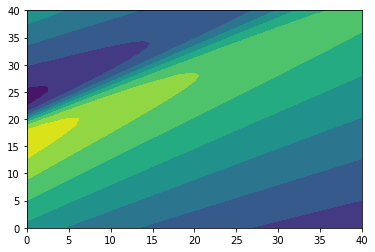

In [ ]:
u = np.loadtxt("../burgers_solution_test04.txt")
plt.contourf(u)

In [ ]:
from burgers_solution import *

In [ ]:
Nx = 201
Nt = 1001

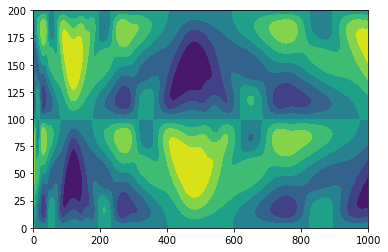

In [ ]:
x = np.linspace(-1., 1., Nx)
t = np.linspace(0., 200., Nt)

u = burgers_viscous_time_exact1 ( nu=nu, vxn=Nx, vx=x, vtn=Nt, vt=t )

plt.contourf(u)

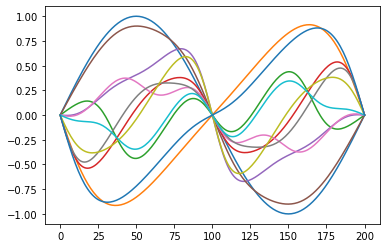

In [ ]:
plt.plot(u[:,::100]);

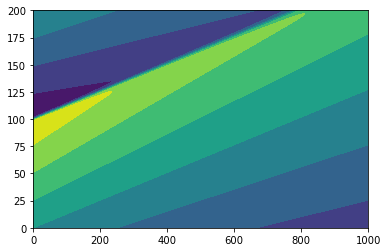

In [ ]:
x = np.linspace(0., 1., Nx) * 2*np.pi
t = np.linspace(0., 1., Nt)

nu = 0.07

u = burgers_viscous_time_exact2 ( nu=nu, xn=Nx, x=x, tn=Nt, t=t )

plt.contourf(u)

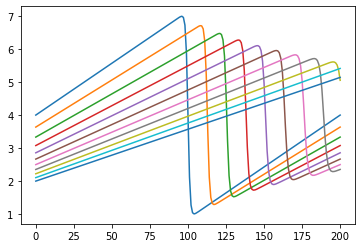

In [ ]:
plt.plot(u[:,::100]);